<a href="https://colab.research.google.com/github/nirnayroy/2d-billiards/blob/master/Copy_of_2d_billiards.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fermi Acceleration in 2d-billiards

# Imports

In [ ]:
!pip install shapely

In [1]:
#@title
import numpy as np
#from scipy import optimize
#from scipy.misc import derivative
import matplotlib.pyplot as plt
#import pickle 
from sklearn.preprocessing import normalize


#from shapely.geometry import LineString
#from shapely.geometry import Point

# Some functions

In [79]:
#slit position
def slit(t, s, omega):
    return -s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


# Travel for rectangle with slit

In [ ]:

#mapping function from one state to the next  
def travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>h:
            print('glitch')
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        vf = -v
        uf = u
        xf = x + u*time_step[di]

        if abs(xf)>l:
            print("glitch")
        elif di==2:
            yf = h
            #print('next wall: top')
        else:
            yf = -h
            #print('next wall: bottom')
    
    p_steps = []
    p_steps.append(t)
    

    if ((v/(s*omega))<1) and ((v/(s*omega))>-1):
        remainder = (np.pi - np.arcsin(v/(s*omega)))/omega
        divisor = (2*np.pi)/omega
        quo = np.floor((t-remainder)/divisor)
        t_bar = quo*divisor + remainder
        while t_bar<tf:
            if t_bar>t:
                p_steps.append(t_bar)
            quo += 1
            t_bar = quo*divisor + remainder

    p_steps.append(tf)
        
    #checking whether collision happens in each time bracket
    for n, i in enumerate(p_steps[0:len(p_steps)-1]):
        if (coll(i, y, v, t, s, omega)*coll(p_steps[n+1], y, v, t, s, omega))<0:
            root = rtsafe(i, p_steps[n+1],y, v, t, s, omega, xacc=0.0000001, maxit = 100)

            #root = optimize.brentq(coll, i, p_steps[n+1], args = (y, v, t, s, omega))
            #print('f at root:',coll(root, y, v, t, s, omega))
            #if coll(root, y, v, t, s, omega)>0.000000001:
                #print('f at root:',coll(root, y, v, t, s, omega))
            #print('roo', 'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
            if root>p_steps[n+1] or root<i:
                print("glitch2:",  'i:',i,' p_steps[n+1]:', p_steps[n+1], 'root:', root)
                #print("p_steps:", p_steps)
             #x when the slit and ball cross
            #conditions for collision
            if abs(x + (u*(root-t)))<lam and abs(y + (v*(root-t)))<s and root!=t:
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v #velocity modified due to collision
                yf =  y + (v*(root-t)) #y when the slit and ball cross
                xf = x + (u*(root-t))
                tf = root
                uf = u
                #print('bar_collsion x:', xf,'y:',  yf, 't:', tf,
                #        'slit_velocity:', dd)
                #print("p_steps:", p_steps)
                break
   
    return (xf, yf, uf, vf, tf)


In [ ]:

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


In [ ]:

def plot_bill(states):
    xs = []
    ys = []
    vs = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        vs.append(v**2)
        xs.append(x)
        ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, vs)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


In [ ]:

omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
    dbfile = open('ensemble2_100', 'ab') 
      
    # source, destination 
    pickle.dump(systems, dbfile)                      
    dbfile.close()
    return systems



In [ ]:

systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)


In [ ]:
import matplotlib.pyplot as plt
def load_and_plot(time_step=1):
    
    dbfile = open('ensemble2', 'rb')      
    systems = pickle.load(dbfile) 
    
    t = 1
    
    tfs = []
    for i in systems:
        last_state = i[len(i)-1]
        #print(last_state)
        (x, y, u, v, tm) = last_state
        tfs.append(tm)
    
    tf = min(tfs)
     
    #print(tf)
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<t2 and t>t1:
                    v += ((v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        #print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

[4333.7531107363575, 4620.855276032316, 5166.599944930533, 5699.88178690181, 6123.237379250558, 6342.2125597567365, 6350.904854983463, 6856.617443316063, 7486.465641915043, 8012.077270917688, 8486.73231278515, 8652.635143721285, 9491.019845687464, 9577.259902409387, 10287.677709275411, 10466.46170717086, 11347.304446746577, 12545.698230169282, 14024.503667592347, 14909.898383584286, 17242.622126118804, 18677.013810298922, 20508.175033088428, 23931.24883240195, 21108.74190138676, 21780.135594746956, 23576.32517277359, 23678.46022377276, 26002.784754953438, 27028.108758986356, 30821.53984096212, 30936.95811236209, 29092.146627217953, 31125.56130226421, 30880.65087704504, 31982.442207685974]
[1, 101, 201, 301, 401, 501, 601, 701, 801, 901, 1001, 1101, 1201, 1301, 1401, 1501, 1601, 1701, 1801, 1901, 2001, 2101, 2201, 2301, 2401, 2501, 2601, 2701, 2801, 2901, 3001, 3101, 3201, 3301, 3401, 3501]


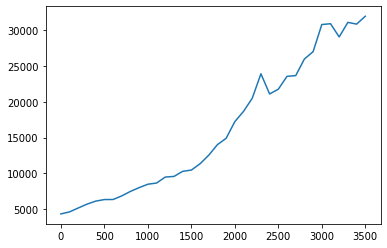

In [ ]:
load_and_plot(time_step=100)

# Stadium Billiards

In [2]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y

def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))


def semicircle_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    r = l #for semi enclosure
    #make sure the ball is moving towards the enclosure
    if v<0:
        print('moving the other direction')

    #defining velocity vector
    vel_vec = np.array([u, v])

    # find where it hits the ball
    # coeffs. for a quadratic equation
    m = (vel_vec[1]/vel_vec[0])
    k = 0
    #print('entered enclosure:', 'x:', x, 'y:', y, 'u:', u, 'v:', v)
    while True:
        
        a = 1+ (m**2)
        b = -2*((m**2)*x - (m*(y-h)))
        c = ((m*x)**2) - (r**2) + ((y-h)**2) - (2*m*x*(y-h))
        disc = (b**2) - (4*a*c) 
        #y = sem_func(x, r)
        #print('x:', x, 'y:', y)
        #print('disc:', (b**2) - (4*a*c) )

        if disc > 0:
            sol1 = (-b-np.sqrt(disc))/(2*a) 
            sol2 = (-b+np.sqrt(disc))/(2*a)
            ysol1 = m*(sol1-x) + y
            ysol2 = m*(sol2-x) + y
            #print('sol1:', sol1, 'sol2:', sol2)
            #print('ysol1:', ysol1, 'ysol2:' ,ysol2)
            if (ysol1>h) != (ysol2>h):
                if k ==0:
                    #print('first collision')
                    if (ysol1>h):
                        xf = sol1
                        yf = ysol1
                    else:
                        xf = sol2
                        yf = ysol2
                else:
                    #print('last collision')
                    yf = h
                    xf = x + ((h-y)/m)
                    ty = (yf-y)/vel_vec[1]
                    tx = (xf-x)/vel_vec[0]
                    if tx - ty > 0.000001:
                        print('failed!: tx', tx, 'ty', ty)
                    t+=ty
                    #print('exit enclosure:', 'x:', xf, 'y:', yf, 'u:', vel_vec[0], 'v:', vel_vec[1])
                    return (xf, yf, vel_vec[0], vel_vec[1], t)
            elif ((ysol1>h) and (ysol2>h)) and k>0:
                if (x - sol1) < 0.000001:
                    xf = sol2
                    yf = ysol2
                else:
                    xf = sol1
                    yf = ysol1
                    
            else:
                print('2 y neg:' ,'ys:', ysol1, ysol2, 'xs', sol1, sol2)
        else:
            
            print('disc_neg')
        
        p = float(d_sem_func(xf, r))
        #print('p:', p)
        if p != 0:
            nor_vec = np.array([-np.sign(p), -np.sign(p)*(1/p)])
            #print('nor vec:', nor_vec)
            nor_vec = normalize(nor_vec.reshape(2, 1))
        else:
            nor_vec = np.array([0, -1]).reshape(2, 1)
        #nor_inc = normalize(vel_vec)
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        #print('ref:', ref, 'ref shape:', ref.shape)
        if np.linalg.norm(vel_vec) - np.linalg.norm(ref)>1e-5:
            print('unnormalized collision:', np.linalg.norm(vel_vec), np.linalg.norm(ref))
        tx = (xf-x)/vel_vec[0]
        ty = (yf-y)/vel_vec[1]
        if tx - ty > 0.0000001:
            print('failed!: tx', tx, 'ty', ty)
        t+=tx
        x = xf
        y = yf
        vel_vec = np.array(ref)
        k += 1
        m = ref[1]/ref[0]
        #print('x:', x, 'y:', y, 'vel_vec:', vel_vec, 'm:', m)
        


#mapping function from one state to the next  
def stadium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 1e8
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        sign = np.sign(yf)
        if abs(yf)>h:
            y_left = abs(yf - (sign*h))
            quo = y_left//(2*h)
            rem = y_left%(2*h)
            if quo%2 == 1:
                yf = sign*(rem-h)
            elif quo%2 == 0:
                yf = sign*(h-rem)
                vf = -v
        if abs(yf)>h:
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            #print('next wall: semi-circle enclosure')
            (xf, yf , uf, vf, tf) = semicircle_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            #print('bottom bar')
            tf1 = tf - (2*s/v)
            tf2 = tf + (2*s/v)
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(i, tf+(np.pi/omega),y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf = xf1 + u*(tf2-root)
                uf = u
                sign = np.sign(xf)
                if abs(xf)>l:
                    x_left = abs(xf - (sign*l))
                    quo = x_left//(2*l)
                    rem = x_left%(2*l)
                    if quo%2 == 1:
                        xf = sign*(rem-l)
                    elif quo%2 == 0:
                        xf = sign*(l-rem)
                        uf = -u
                yf = -h
                
                
            else:
                print('root out of bounds')
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = stadium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states

'''
def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()


res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)
'''

    


    


'\ndef plot_bill(states):\n    #xs = []\n    #ys = []\n    es = []\n    ts = []\n    for i in states:\n        (x, y, u, v, t) = i\n        es.append((v**2)+(u**2))\n        #xs.append(x)\n        #ys.append(y)\n        ts.append(t)\n    #plt.scatter(xs, ys)\n    #plt.xlim(-20, 20)\n    #plt.ylim(-10, 10)\n    #plt.show()\n    plt.plot(ts, es)\n    plt.show()\n\n\nres = iteration(xi =-0.70, yi=-0.65, ui = ui, \n                vi =vi,\n                omega=omega, lam=1, l=2, h=1,s = 0.1, \n                ni=10000)\nplot_bill(res)\n'

In [3]:
import matplotlib.pyplot as plt


omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
        print(k)
    return systems
      
    # source, destination 
                   
    
omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1



systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)
#np.save('stadium_100.npy', systems)   

print('saved!!')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
saved!!


In [5]:

    
#    systems = numpy.load("mydata.npy")

    


(array([0.36313779]), 1, array([5.02053607]), array([-5.02426139]), array([46259.82436154]))
(array([-1.53975283]), -1, array([0.96486837]), array([6.85263392]), array([69361.8779178]))
(array([-1.00003804]), 1, array([-5.1162254]), array([-5.11332932]), array([45178.06671937]))
(array([1.16038403]), 1, array([4.89575372]), array([-4.8942286]), array([45084.80856439]))
(array([-1.73726578]), -1, array([-4.99341179]), array([4.99289873]), array([46339.24867729]))
(array([-0.94520956]), -1, array([-5.12954213]), array([5.12921493]), array([45045.05877694]))
(2, array([-0.20183119]), array([-5.0667608]), array([-5.0622728]), array([45588.76930816]))
(array([0.42400201]), -1, array([-5.00361369]), array([5.01710043]), array([42646.29205614]))
(array([1.3135541]), 1, array([-4.87896571]), array([-4.88167646]), array([45002.98314513]))
(array([-0.76401892]), 1, array([-5.1106155]), array([-5.10703793]), array([45735.54946082]))
(array([-1.06538933]), -1, array([-5.1032752]), array([5.1134859

(array([-0.8532411]), -1, array([-4.97039082]), array([4.96629746]), array([44376.33033285]))
(array([0.97572561]), 1, array([4.9641306]), array([-4.96046792]), array([45511.52678418]))
(array([1.02519824]), 1, array([5.12341988]), array([-5.12493411]), array([45119.72371897]))
(array([-0.74397008]), 1, array([4.93223409]), array([-4.93184645]), array([46341.33963326]))
(array([-1.80026786]), -1, array([-5.01847221]), array([5.00895433]), array([46400.93533699]))
(array([-0.95635613]), -1, array([-4.97289569]), array([4.97646097]), array([44732.74775778]))
(array([0.88101091]), -1, array([5.07420505]), array([5.08533952]), array([44893.93740903]))
(-2, array([-0.00785894]), array([5.11975001]), array([-5.12010915]), array([45326.97176536]))
(2, array([0.18291922]), array([-4.95453406]), array([-4.95847588]), array([45688.07132573]))
(array([0.45567264]), -1, array([-5.09344327]), array([5.09423717]), array([42593.90216723]))
(array([0.46084251]), -1, array([-5.03408776]), array([5.0447

101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101
4201
4301
4401
4501
4601
4701
4801
4901
5001
5101
5201
5301
5401
5501
5601
5701
5801
5901
6001
6101
6201
6301
6401
6501
6601
6701
6801
6901
7001
7101
7201
7301
7401
7501
7601
7701
7801
7901
8001
8101
8201
8301
8401
8501
8601
8701
8801
8901
9001
9101
9201
9301
9401
9501
9601
9701
9801
9901
10001
10101
10201
10301
10401
10501
10601
10701
10801
10901
11001
11101
11201
11301
11401
11501
11601
11701
11801
11901
12001
12101
12201
12301
12401
12501
12601
12701
12801
12901
13001
13101
13201
13301
13401
13501
13601
13701
13801
13901
14001
14101
14201
14301
14401
14501
14601
14701
14801
14901
15001
15101
15201
15301
15401
15501
15601
15701
15801
15901
16001
16101
16201
16301
16401
16501
16601
16701
16801
16901
17001
17101
17201
17301
17401
17501
17601
17701
17801
17901
18001
18101
18201
18301
18401
1850

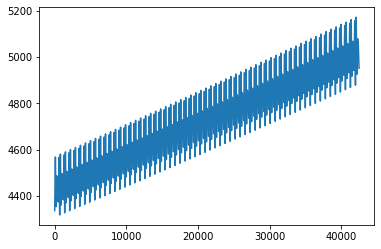

In [8]:
def load_and_plot(time_step=1):
    t = 1
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                #print(i,j)
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<=t2 and t>=t1:
                    v += ((u1)**2+(v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

load_and_plot(time_step=100)

## Trapezium Billiards

In [156]:
def trapezium_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    if v<0:
        print('moving the other direction')
    st = 'en'
    vel_vec = np.array([u, v])
    
    if u == 0:
        m = np.inf
    else:
        m = v/u
    slope = 1
    wall_y_left = h
    wall_y_right = slope*(2*l)+h
    while True:
        ball_y_right = m*(l-x)+y 
        ball_y_left = m*(-l-x)+y 
        if m == slope:
            x_int = 3
        else:
            x_int = (h-y+(slope*l)+(m*x))/(m-slope)
        print(x_int)
        if ((-l<x_int) and (x_int<l)) and st != "sl" :
            print('slop')
            xf = x_int
            yf = m*(xf-x)+y
            nor_vec = normalize(np.array([1, -(1/slope)]).reshape(2,1))
            st = "sl"
        elif h < ball_y_right < wall_y_right and st != "ve":
            #hit vertical
            print('vert')
            xf = l
            yf = ball_y_right
            nor_vec = normalize(np.array([-1, 0]).reshape(2,1))
            st = "ve"

        else:
            print('exit')
            yf = h
            xf = x + ((h-y)/vel_vec[1])* vel_vec[0]
            t += (h-y)/vel_vec[1]
            if vel_vec[1]>0:
                print('other way:', (h-y)/vel_vec[1])
            return (xf, yf, vel_vec[0], vel_vec[1], t)
                
        t += (xf-x)/vel_vec[0]
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        if np.linalg.norm(vel_vec) != np.linalg.norm(ref):
            print('unnormalized collision')
        x = xf
        y = yf
        vel_vec = np.array(ref)
        print(ref)
        m = float(ref[1]/ref[0])
        
omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
#entered enclosure: x: [-1.30463345] y: 1 u: [-0.70840413] v: [0.70580705]
trapezium_enclosure(x=0, y=h , u=1, v=1, t=0, lam=1, l=l, h=h, s=s, omega=omega)  
                              

3
vert
[[-1.]
 [ 1.]]
1.0
slop
[[ 1.]
 [-1.]]
1.0
vert
[[-1.]
 [-1.]]
3
exit


(array([0.]), 1, array([-1.]), array([-1.]), array([6.]))

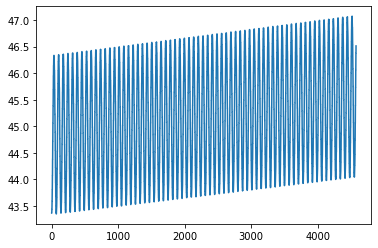

In [7]:
#slit position
def slit(t, s, omega):
    return -h-s*np.cos(omega*t)

#slit velocity
def der_slit(t, s, omega):
    return s*np.sin(omega*t)*omega
    
#ball position
def ball(t, y, v, t0):
    return (y+(v*(t-t0)))

#difference between position of ball and slit
def coll(t, y, v, t0, s, omega):
    return (slit(t, s, omega)-ball(t, y, v, t0))

#derivative of the above function
def der_coll(t, v,  s, omega):
    return der_slit(t, s, omega) - v

#root finding function
def rtsafe(x1, x2, y, v, t, s, omega, xacc=0.0001, maxit = 100):
    fl = coll(x1, y, v, t, s, omega)
    fh = coll(x2, y, v, t, s, omega)
    if (fl>0 and fh>0) or (fl<0 and fh<0):
        print ('root not bracketed')
    if fl==0:
        rtsafe = x1
        return rtsafe
    
    elif fh==0:
        rtsafe = x2
        return rtsafe
    
    elif fl<0:
        xl = x1
        xh = x2

    else:
        xh = x1
        xl = x2

    rtsafe = 0.5*(x1+x2)
    dxold = abs(x2-x1)
    dx = dxold

    f = coll(rtsafe, y, v, t, s, omega)
    df = der_coll(rtsafe, v, s, omega)
    j = 1
    while j<maxit:
        if (((rtsafe-xh)*df-f)*((rtsafe-xl)*df-f))>0 or (abs(2.*f) > abs(dxold*df)):
            dxold = dx
            dx = 0.5*(xh-xl)
            rtsafe = xl+dx
            if xl == rtsafe:
                return rtsafe
        else:
            dxold = dx
            dx = f/df
            temp = rtsafe
            rtsafe = rtsafe-dx
            if temp == rtsafe:
                return rtsafe
        if (abs(dx)  < xacc):
            return rtsafe
        
        f = coll(rtsafe, y, v, t, s, omega)
        df = der_coll(rtsafe, v,  s, omega)

        if (f < 0 ):
            xl = rtsafe
        else:
            xh = rtsafe
    
        j += 1
    print("steps exceeded")
    return None


def line2cord(m, x_0, h, x):
    y = m*(x - x_0) + h
    return y
'''
def sem_func(x, r):
    return np.sqrt((r**2)-(x**2))

def d_sem_func(x, r):
    return (x/np.sqrt((r**2)-(x**2)))

'''
def trapezium_enclosure(x, y , u, v, t, lam, l, h, s, omega):
    if v<0:
        print('moving the other direction')
    st = 'en'
    vel_vec = np.array([u, v])
    
    if u == 0:
        m = np.inf
    else:
        m = v/u
    slope = 1
    wall_y_left = h
    wall_y_right = slope*(2*l)+h
    while True:
        ball_y_right = m*(l-x)+y 
        ball_y_left = m*(-l-x)+y 
        if m == slope:
            x_int = 3
        else:
            x_int = (h-y+(slope*l)+(m*x))/(m-slope)
        #print(x_int)
        if ((-l<x_int) and (x_int<l)) and st != "sl" :
            #print('slop')
            xf = x_int
            yf = m*(xf-x)+y
            nor_vec = normalize(np.array([1, -(1/slope)]).reshape(2,1))
            st = "sl"
        elif h < ball_y_right < wall_y_right and st != "ve":
            #hit vertical
            #print('vert')
            xf = l
            yf = ball_y_right
            nor_vec = normalize(np.array([-1, 0]).reshape(2,1))
            st = "ve"

        else:
            #print('exit')
            yf = h
            xf = x + ((h-y)/vel_vec[1])* vel_vec[0]
            t += (h-y)/vel_vec[1]
            if vel_vec[1]>0:
                print('other way:', (h-y)/vel_vec[1])
            return (xf, yf, vel_vec[0], vel_vec[1], t)
                
        t += (xf-x)/vel_vec[0]
        vel_vec = vel_vec.reshape(2,1)
        ref = np.array(vel_vec - (2*np.dot(np.transpose(nor_vec), vel_vec)*nor_vec))
        ref = ((np.linalg.norm(vel_vec)/np.linalg.norm(ref))*ref).reshape(2, 1)
        if np.linalg.norm(vel_vec) - np.linalg.norm(ref)> 1e-5:
            print('unnormalized collision')
        x = xf
        y = yf
        vel_vec = np.array(ref)
        #print(ref)
        m = float(ref[1]/ref[0])
        


#mapping function from one state to the next  
def trapezium_travel(x, y , u, v, t, lam, l, h, s, omega):
    lt = (-l - x)/u #time it would take to hit left wall
    rt = (l-x)/u    #time it would take to hit right wall
    ut = (h-y)/v    #time it would take to hit top wall which 
                    #is in contact with the semi-circle enclosure.
    dt = (-h-y)/v   #time it would take to hit bottom wall
    time_step = [lt, rt, ut, dt] #feeding it into an array
    #print('t_left:',time_step[0], 't_right:',time_step[1], 
    #       't_top:',time_step[2], 't_bottom:',time_step[3])
    
    #mechanism to find the lowest positive number
    for n, i in enumerate(time_step):
        if i<=0:
            time_step[n] = 10000000
    di = np.argmin(time_step) #index of the lowest positive number
    tf = t + time_step[di] #time at which the next wall would be hit

    # if the collision is with left or right wall
    if di==0 or di == 1:
        uf = -u
        vf = v
        yf = y + v*time_step[di]
        if abs(yf)>(h+s):
            print('glitch: yf', yf, 'y', y, 'v', v, 'dt:', time_step[di])
        elif di==0:
            xf = -l
            #print('next wall: left')
        else:
            xf = l
            #print('next wall: right')
    
    #if collision is with top or bottom wall
    if di==2 or di==3:
        if di==2:
        
            yf = h
            xf = x + u*time_step[di]
            #print('next wall: trapezium enclosure')
            (xf, yf , uf, vf, tf) = trapezium_enclosure(xf, yf , u, v, tf, lam, l, h, s, omega)
            if (yf != h) or (abs(xf)>l):
                print('glitch2:', 'x:', xf, 'y:', yf, 'u:', uf, 'v:', vf) 
            
        else:
            #print('bottom bar')
            tf1 = tf - (2*s/v)
            tf2 = tf + (2*s/v)
            xf1 = x + u*time_step[di]
            if (coll(tf1, y, v, t, s, omega)*coll(tf2, y, v, t, s, omega))<0:
                root = rtsafe(i, tf+(np.pi/omega),y, v, t, s, omega, xacc=0.0000001, maxit = 100)
                dd = der_slit(root ,s , omega) #velocity of slit
                vf = (2*dd) - v
                y_coll = slit(root ,s , omega)
                tf2 = root + ((-h-y_coll)/vf)
                xf = xf1 + u*(tf2-root)
                uf = u
                sign = np.sign(xf)
                if abs(xf)>l:
                    x_left = abs(xf - (sign*l))
                    quo = x_left//(2*l)
                    rem = x_left%(2*l)
                    if quo%2 == 1:
                        xf = sign*(rem-l)
                    elif quo%2 == 0:
                        xf = sign*(l-rem)
                        uf = -u
                yf = -h
            else:
                print('root out of bounds')
            
    return (xf, yf, uf, vf, tf)

def iteration(xi, yi, ui, vi, omega, lam, l, h, s, ni, t=0):
    state_tup = (xi, yi, ui, vi, t)
    #print('x =', state_tup[0], 'y=', state_tup[1], 
    #         'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
    states  = []
    states.append(state_tup)
    k = 0
    while k<ni:
        (x, y, u, v, tf) = trapezium_travel(xi, yi , ui, vi, t, lam, l, h, s, omega)
        state_tup = (x, y, u, v, tf)
        #print('\nx =', state_tup[0], 'y=', state_tup[1], 
        #      'u=', state_tup[2], 'v=', state_tup[3], 't=', state_tup[4])
        states.append(state_tup)
        (xi, yi, ui, vi, t) = (x, y, u, v, tf)
        k += 1
    n_osc = int((omega*t)/(2*np.pi))
    #print(n_osc)
    return states


def plot_bill(states):
    #xs = []
    #ys = []
    es = []
    ts = []
    for i in states:
        (x, y, u, v, t) = i
        es.append((v**2)+(u**2))
        #xs.append(x)
        #ys.append(y)
        ts.append(t)
    #plt.scatter(xs, ys)
    #plt.xlim(-20, 20)
    #plt.ylim(-10, 10)
    #plt.show()
    plt.plot(ts, es)
    plt.show()

omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1
res = iteration(xi =-0.70, yi=-0.65, ui = ui, 
                vi =vi,
                omega=omega, lam=1, l=2, h=1,s = 0.1, 
                ni=10000)
plot_bill(res)


    

In [8]:
import matplotlib.pyplot as plt


omega=(2*np.pi/70)
lam = 1
def save_ensemble_states(ui= ((4*lam*omega)/np.sqrt(5)),
                vi=(41*((4*lam*omega)/np.sqrt(5))), 
                omega=(2*np.pi/70), 
                lam=1, l=2, h=1,s = 0.1,  ni=10000, 
                ensemble_size = 100):
    k = 0
    systems = []
    while k<ensemble_size:
        res = iteration(xi = np.random.uniform(-l,l), 
                        yi= np.random.uniform(-h,h),
                        ui= ui,
                vi=vi, omega=omega, 
                lam=lam, l=l, h=h,s = s,  ni=ni)
        systems.append(res)
        k+=1
        print(k)
    return systems
      
    # source, destination 
                   
    
omega=(2*np.pi/70) 
lam=1
ui= ((4*lam*omega)/np.sqrt(5))
vi=(41*((4*lam*omega)/np.sqrt(5)))
l=2
h=1
s = 0.1



systems = save_ensemble_states(ui= ui,
                vi=vi, 
                omega=omega, 
                lam=lam, l=l, h=h,s = s, ni=100000)
#np.save('stadium_100.npy', systems)   

print('saved!!')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
saved!!


In [9]:
tfs = []
for i in systems:
    last_state = i[len(i)-1]
    print(last_state)
    (x, y, u, v, tm) = last_state
    tfs.append(tm)

tf = min(tfs)
print(tf)

(array([1.57935223]), -1, array([5.12733741]), array([5.11635411]), array([40785.37514461]))
(array([0.78716383]), 1, array([-5.08547391]), array([-5.08209581]), array([68346.42917151]))
(-2, array([-0.40815265]), array([5.09511114]), array([5.08907492]), array([68359.86268337]))
(array([0.47639895]), -1, array([-5.16097687]), array([5.16126556]), array([40774.33933572]))
(2, array([0.49334693]), array([-5.13327028]), array([5.12323812]), array([40784.52620067]))
(array([0.75541787]), -1, array([5.03909101]), array([5.0270018]), array([40797.38478636]))
(-2, array([-0.60811013]), array([5.08800978]), array([-5.08480749]), array([68347.69170079]))
(array([-0.20965177]), 1, array([-5.0917307]), array([-5.09367131]), array([68361.1224415]))
(-2, array([-0.94065016]), array([5.0014842]), array([5.00575247]), array([68323.09034285]))
(array([0.57629927]), 1, array([5.16105419]), array([-5.16106232]), array([40775.68364413]))
(array([0.42987269]), 1, array([5.16126118]), array([-5.16107217])

101
201
301
401
501
601
701
801
901
1001
1101
1201
1301
1401
1501
1601
1701
1801
1901
2001
2101
2201
2301
2401
2501
2601
2701
2801
2901
3001
3101
3201
3301
3401
3501
3601
3701
3801
3901
4001
4101
4201
4301
4401
4501
4601
4701
4801
4901
5001
5101
5201
5301
5401
5501
5601
5701
5801
5901
6001
6101
6201
6301
6401
6501
6601
6701
6801
6901
7001
7101
7201
7301
7401
7501
7601
7701
7801
7901
8001
8101
8201
8301
8401
8501
8601
8701
8801
8901
9001
9101
9201
9301
9401
9501
9601
9701
9801
9901
10001
10101
10201
10301
10401
10501
10601
10701
10801
10901
11001
11101
11201
11301
11401
11501
11601
11701
11801
11901
12001
12101
12201
12301
12401
12501
12601
12701
12801
12901
13001
13101
13201
13301
13401
13501
13601
13701
13801
13901
14001
14101
14201
14301
14401
14501
14601
14701
14801
14901
15001
15101
15201
15301
15401
15501
15601
15701
15801
15901
16001
16101
16201
16301
16401
16501
16601
16701
16801
16901
17001
17101
17201
17301
17401
17501
17601
17701
17801
17901
18001
18101
18201
18301
18401
1850

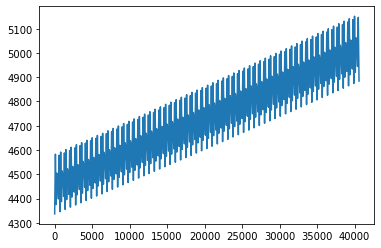

In [10]:
def load_and_plot(time_step=1):
    t = 1
    vels = []
    ts = []
    while t<tf:
        v = 0
        for i in systems:
            for n, j in enumerate(i[0:(len(i)-1)]):
                #print(i,j)
                (x1, y1, u1, v1, t1) = j
                (x2, y2, u2, v2, t2) = i[n+1]
                if t<=t2 and t>=t1:
                    v += ((u1)**2+(v1)**2)
                    break
        vels.append(v)
        ts.append(t)
        t += time_step
        print(t)
        #print(v)
    print(vels)
    print(ts)
    
    plt.plot(ts, vels)
    plt.show()
   
        

load_and_plot(time_step=100)